# Notebook for practical exercises | Week #6 Lesson #1


#### Fusing Images and Metadata

In this notebook, we will explore multi-modal data integration. Our goal is to improve the diagnostic accuracy of a chest X-ray classifier by combining two distinct types of data:
1.  Image Data: The chest X-ray images themselves.
2.  Tabular Data: Structured patient demographics, specifically 'Patient Age' and 'Patient Sex'.

Using the [NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset with demographic categories. Demographic information can be a powerful predictor for many diseases. For example, the likelihood of certain conditions changes significantly with age. By teaching our model to consider both the visual patterns in the X-ray and the patient's metadata, we hope to build a more accurate and context-aware diagnostic tool.

We will implement and compare two common fusion strategies:
*   Concatenation-based Fusion: A simple and robust method where features from both modalities are combined and fed to a classifier.
*   Attention-based Fusion: A more sophisticated method where the tabular data "gates" or modulates the image features, allowing the model to learn context-specific visual patterns.
*   Bilinear Pooling Fusion: An expressive method that models pairwise feature interactions.

Compare their validation AUC and metrics, and discuss which fusion strategy performs best and why.

Your task is to complete the code snippets marked with `# COMPLETE`, run the training, and analyze the results.

## Dataset

[NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels (where each image can have multi-labels), mined from the associated radiological reports using natural language processing.
Fourteen common thoracic pathologies include Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, Cardiomegaly, Nodule, Mass and Hernia.

It contains:
1. 112,120 frontal-view chest X-ray PNG images in 1024*1024 resolution (under images folder)
2. Meta data for all images (Data_Entry_2017.csv): Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, Original Image Size and Original Image Pixel Spacing.
3. Bounding boxes for ~1000 images (BBox_List_2017.csv): Image Index, Finding Label, Bbox[x, y, w, h]. [x y] are coordinates of each box's topleft corner. [w h] represent the width and height of each box.
4. The data split from previous week
Here, we will use a subsample of this dataset along with pretrained models from the last week.

## Download

In [2]:
DATA_PATH = "./"
!curl https://uni-bonn.sciebo.de/s/ya8ezZDk9yR3NWB/download/test_df.csv --output {DATA_PATH}/test_df.csv
!curl https://uni-bonn.sciebo.de/s/yfSiQQPJex6zaPq/download/train_df.csv --output {DATA_PATH}/train_df.csv
!curl https://uni-bonn.sciebo.de/s/PpSnH6r5WGg75Mz/download/val_df.csv --output {DATA_PATH}/val_df.csv

!curl https://uni-bonn.sciebo.de/s/97mg2KaEkC2id7c/download/densenet121-classification.pth --output {DATA_PATH}/densenet121-classification.pth
!curl https://uni-bonn.sciebo.de/s/cTgsNw4bg6cQmqG/download/concat_model_best_auc.pth --output {DATA_PATH}/concat_model_best_auc.pth
!curl https://uni-bonn.sciebo.de/s/LjM2xfxTwbtQC9k/download/attention_model_best_auc.pth --output {DATA_PATH}/attention_model_best_auc.pth
!curl https://uni-bonn.sciebo.de/s/W7qd6BSQKyk9XtX/download/bilinear_model_best_auc.pth --output {DATA_PATH}/bilinear_model_best_auc.pth

!curl https://uni-bonn.sciebo.de/s/J3GFK3bsHGDfwAC/download/data_cxr8.zip --output {DATA_PATH}/data.zip
!unzip {DATA_PATH}/data.zip -d {DATA_PATH}

Streaming output truncated to the last 5000 lines.
  inflating: ./images/00020408_013.png  
  inflating: ./images/00020408_015.png  
  inflating: ./images/00020408_018.png  
  inflating: ./images/00020408_023.png  
  inflating: ./images/00020408_026.png  
  inflating: ./images/00020408_034.png  
  inflating: ./images/00020408_039.png  
  inflating: ./images/00020408_041.png  
  inflating: ./images/00020408_042.png  
  inflating: ./images/00020408_043.png  
  inflating: ./images/00020408_045.png  
  inflating: ./images/00020408_048.png  
  inflating: ./images/00020408_051.png  
  inflating: ./images/00020408_056.png  
  inflating: ./images/00020408_060.png  
  inflating: ./images/00020408_061.png  
  inflating: ./images/00020410_001.png  
  inflating: ./images/00020410_002.png  
  inflating: ./images/00020410_005.png  
  inflating: ./images/00020410_006.png  
  inflating: ./images/00020410_007.png  
  inflating: ./images/00020415_002.png  
  inflating: ./images/00020419_000.png  
  infl

In [3]:
#@title import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings(action="ignore")

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from PIL import Image
from tqdm import tqdm

import random
def set_seed(seed):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed set to {seed}")

set_seed(42)

Seed set to 42


## Load data

In [4]:
# Load the data splits
DATA_PATH = './' # Ensure this path is correct
train_df = pd.read_csv(f'{DATA_PATH}/train_df.csv')
val_df = pd.read_csv(f'{DATA_PATH}/val_df.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test_df.csv') # Renaming to test_df for clarity

IMG_DIR = f'{DATA_PATH}/images'
train_df['ImagePath'] = train_df['Image Index'].apply(lambda x: os.path.join(IMG_DIR, x))
val_df['ImagePath'] = val_df['Image Index'].apply(lambda x: os.path.join(IMG_DIR, x))
test_df['ImagePath'] = test_df['Image Index'].apply(lambda x: os.path.join(IMG_DIR, x))

print("Data loaded successfully.")
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Data loaded successfully.
Training samples: 2160
Validation samples: 540
Test samples: 558


## Preprocessing Tabular Data

Before we can feed our demographic data into a neural network, it needs to be preprocessed into a numerical format.
*   Patient Age: This is a continuous feature. We will normalize it to a range between 0 and 1 to help with stable model training.
*   Patient Sex: This is a categorical feature ('M' or 'F'). We will convert it into a one-hot encoded vector. For example, `F` becomes `[1, 0]` and `M` becomes `[0, 1]`.

Your first task is to preprocess the demographic data

In [5]:
# Normalize Age
# We'll use the min and max age from the training set for normalization
min_age = train_df['Patient Age'].min()
max_age = train_df['Patient Age'].max()

def normalize_age(age):
    # COMPLETE: Normalize the age using min_age and max_age
  return (age - min_age) / (max_age - min_age)# COMPLETE

# One-Hot Encode Sex
def one_hot_sex(sex):
    # COMPLETE: Return [1, 0] for 'F' and [0, 1] for 'M'
 return [1, 0] if sex == 'F' else [0, 1] # COMPLETE


In [6]:
sample_row = train_df.iloc[0]
age_norm = normalize_age(sample_row['Patient Age'])
sex_onehot = one_hot_sex(sample_row['Patient Sex'])
tabular_vector = np.array([age_norm] + sex_onehot, dtype=np.float32)

print(f"Sample Patient Age: {sample_row['Patient Age']}, Sex: {sample_row['Patient Sex']}")
print(f"Processed Tabular Vector: {tabular_vector}")
print(f"Size of our tabular feature vector: {len(tabular_vector)}")

Sample Patient Age: 63, Sex: F
Processed Tabular Vector: [0.7126437 1.        0.       ]
Size of our tabular feature vector: 3


## Creating the `MultiModalDataset`

Now, create a custom PyTorch `Dataset`. This class needs to return three items for each sample: the image tensor, the processed tabular vector, and the label.

Complete the `__getitem__` method to process and return the correct tensors.

In [7]:
class MultiModalDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df
        self.image_paths = df['ImagePath'].tolist()
        self.ages = df['Patient Age'].tolist()
        self.sexes = df['Patient Sex'].tolist()
        self.labels = df['Binary Label'].tolist()

        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        if is_train:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Image Processing
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image_tensor = self.transform(image)

        # COMPLETE: Tabular Data Processing
        # 1. Get the normalized age for the patient at index `idx`
        # 2. Get the one-hot encoded sex for the patient at index `idx`
        # 3. Combine them into a single tensor named `tabular_tensor`
        age_norm = normalize_age(self.ages[idx]) # COMPLETE
        sex_onehot = one_hot_sex(self.sexes[idx])# COMPLETE
        tabular_tensor = torch.tensor([age_norm] + sex_onehot, dtype=torch.float32) # COMPLETE

        # Label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image_tensor, tabular_tensor, label

Define the `MultiModalDataset` and `Datalaoders`

In [8]:
# Create datasets
train_dataset = MultiModalDataset(train_df, is_train=True)
val_dataset = MultiModalDataset(val_df, is_train=False)
test_dataset = MultiModalDataset(test_df, is_train=True)

# Create dataloaders with drop_last=True to avoid the shape mismatch error
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    drop_last=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False
)
test_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False
)


### Building the Fusion Models


#### The Image Feature Extractor

Both of our fusion models will use a pre-trained `DenseNet-121` as a backbone to extract high-level features from the chest X-rays. We will freeze the majority of its layers to prevent the pre-trained weights from being altered too much during our short training session.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_image_backbone():
    # Load pre-trained DenseNet-121
    densenet = models.densenet121()
    densenet.classifier = nn.Linear(densenet.classifier.in_features, 1)
    densenet.load_state_dict(torch.load('./densenet121-classification.pth', map_location=device))

    # Freeze all layers
    for param in densenet.parameters():
        param.requires_grad = False

    # Unfreeze the final dense block and the classifier to fine-tune
    for param in densenet.features.denseblock4.parameters():
        param.requires_grad = True

    # Get the number of output features from the backbone
    num_features = densenet.classifier.in_features

    # Remove the final classifier layer
    densenet.classifier = nn.Identity()

    return densenet, num_features

# Test it
backbone, num_img_features = get_image_backbone()
print(f"DenseNet backbone loaded. Output feature size: {num_img_features}")


DenseNet backbone loaded. Output feature size: 1024



#### Model 1: Concatenation-based Fusion

This is our first fusion model. The strategy is straightforward:
1.  Extract a feature vector from the image using our `DenseNet` backbone.
2.  Process the tabular data through its own small neural network (an MLP).
3.  Concatenate the two resulting feature vectors.
4.  Pass this final combined vector through a classifier to get a prediction.

You will implement the `forward` pass for three different fusion architectures as described in the lecture. The `__init__` methods are provided for you.

Your task is to complete the `forward` method for each of the three models below.


In [10]:
class ConcatenationModel(nn.Module):
    def __init__(self, num_img_features, num_tabular_features, hidden_size=128):
        super().__init__()
        self.image_backbone, _ = get_image_backbone()
        self.tabular_mlp = nn.Sequential(nn.Linear(num_tabular_features, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size))
        self.classifier = nn.Sequential(nn.Linear(num_img_features + hidden_size, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 1))

    def forward(self, image, tabular_data):
        # 1. Get image features from the backbone
        img_features = self.image_backbone(image)
        # 2. Get tabular features from the tabular MLP
        tab_features = self.tabular_mlp(tabular_data)

        # COMPLETE: 3. Concatenate the two feature vectors along dimension 1
        combined_features = torch.cat([img_features, tab_features], dim=1)# COMPLETE

        # 4. Pass the combined features through the classifier
        output = self.classifier(combined_features)
        return output


#### Model 2: Attention-based Fusion (Gated Multi-Modal Unit)

Our second model is more advanced. Instead of just combining features, it uses the tabular data to create a "gating" mechanism that modulates the image features. The model learns which visual patterns are more or less important based on the patient's age and sex.

1.  Extract image features.
2.  Process tabular data to get tabular features.
3.  Pass the tabular features through a `sigmoid` function to create a "gate" vector with values between 0 and 1.
4.  Multiply the image features by this gate (element-wise). This is the attention mechanism.
5.  Concatenate the *gated* image features with the original tabular features.
6.  Pass the result through the final classifier.

In [11]:
class AttentionFusionModel(nn.Module):
    def __init__(self, num_img_features, num_tabular_features, hidden_size=128):
        super().__init__()
        self.image_backbone, _ = get_image_backbone()
        self.tabular_mlp = nn.Sequential(nn.Linear(num_tabular_features, hidden_size), nn.ReLU())
        self.gate = nn.Sequential(nn.Linear(hidden_size, num_img_features), nn.Sigmoid())
        self.classifier = nn.Sequential(nn.Linear(num_img_features + hidden_size, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 1))

    def forward(self, image, tabular_data):
        img_features = self.image_backbone(image)
        tab_features = self.tabular_mlp(tabular_data)

        # COMPLETE:
        # 1. Generate the attention gate from the tabular features
        attention_gate = self.gate(tab_features) # COMPLETE
        # 2. Apply the gate to the image features (element-wise multiplication)
        gated_img_features = img_features * attention_gate# COMPLETE
        # 3. Concatenate the *gated* image features with the original tabular features
        combined_features = torch.cat([gated_img_features, tab_features], dim=1) # COMPLETE

        output = self.classifier(combined_features)
        return output

#### Model 3: Attention-based Fusion (Gated Multi-Modal Unit)

Bilinear Pooling Fusion

This model uses Bilinear Pooling to capture more expressive feature interactions. Unlike concatenation, which simply appends feature vectors, bilinear pooling computes the outer product of the image and tabular features. This creates a much richer representation that explicitly models the multiplicative (or pairwise) interaction between every feature from the image and every feature from the metadata.

1.  Extract image features using the `DenseNet` backbone.
2.  Process tabular data through its own MLP to get tabular features.
3.  A `Bilinear` layer combines the image and tabular features, considering all pairwise products.
4.  The output is passed to a final classifier. This method is computationally more intensive but can capture complex feature correlations.

In [12]:
class BilinearFusionModel(nn.Module):
    def __init__(self, num_img_features, num_tabular_features, hidden_size=128, output_size=512):
        super().__init__()
        self.image_backbone, _ = get_image_backbone()
        self.tabular_mlp = nn.Sequential(nn.Linear(num_tabular_features, hidden_size), nn.ReLU())
        self.bilinear = nn.Bilinear(num_img_features, hidden_size, output_size)
        self.classifier = nn.Sequential(nn.ReLU(), nn.Dropout(0.2), nn.Linear(output_size, 1))

    def forward(self, image, tabular_data):
        img_features = self.image_backbone(image)
        tab_features = self.tabular_mlp(tabular_data)

        # COMPLETE:
        # 1. Apply the bilinear layer to the image and tabular features
        fused_features = self.bilinear(img_features, tab_features)


        output = self.classifier(fused_features)
        return output


### Training and Evaluation

#### Training and Validation Loop

We'll define our training and validation functions. We will train each model for a small number of epochs (3-5) and monitor the validation AUC at the end of each epoch.

Now you will train the models you just built. The training and validation helper functions are provided.

Your task is to instantiate the three models and then run the training loop.

In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, tabular, labels in tqdm(dataloader, desc="Training"):
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, tabular, labels in tqdm(dataloader, desc="Validating"):
            images, tabular = images.to(device), tabular.to(device)

            outputs = model(images, tabular)
            probs = torch.sigmoid(outputs.squeeze())

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return all_labels, all_probs

# Training Setup

#### Train the Concatenation Model

In [14]:
# Load the saved model
concat_model = ConcatenationModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device)

concat_model.load_state_dict(torch.load('concat_model_best_auc.pth', map_location=device))
concat_model.eval() # Set the model to evaluation mode
print("Concatenation Model loaded successfully.")

Concatenation Model loaded successfully.


In [15]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
# COMPLETE: Instantiate
print("--- Training Concatenation Model ---")
concat_model = ConcatenationModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device)
optimizer_concat = torch.optim.Adam(concat_model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 10
concat_aucs = []
concat_accuracies = []
concat_precisions = []
concat_recalls = []
concat_f1s = []

best_auc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        concat_model, train_loader, optimizer_concat, criterion, device
    )

    # Validation
    all_labels, all_probs = validate(concat_model, val_loader, device)
    val_auc = roc_auc_score(all_labels, all_probs)

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)

    # Binarize probs at 0.5
    val_preds = (all_probs >= 0.5).astype(int)

    # Compute other metrics
    val_acc   = accuracy_score(all_labels, val_preds)
    val_prec  = precision_score(all_labels, val_preds, zero_division=0)
    val_rec   = recall_score(all_labels, val_preds, zero_division=0)
    val_f1    = f1_score(all_labels, val_preds, zero_division=0)

    # Store for plotting later
    concat_aucs.append(val_auc)
    concat_accuracies.append(val_acc)
    concat_precisions.append(val_prec)
    concat_recalls.append(val_rec)
    concat_f1s.append(val_f1)

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{num_epochs} — "
        f"Train Loss: {train_loss:.4f} | "
        f"Val AUC: {val_auc:.4f} | "
        f"Acc: {val_acc:.4f} | "
        f"Prec: {val_prec:.4f} | "
        f"Rec: {val_rec:.4f} | "
        f"F1: {val_f1:.4f}"
    )

    # Save the best model
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = concat_model.state_dict()
        print(f"  → New best validation AUC: {best_auc:.4f}. Saving model state.")

# load the best model state after training
if best_model_state is not None:
    concat_model.load_state_dict(best_model_state)
    print("Loaded best model state for Concatenation Model.")


--- Training Concatenation Model ---


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.65it/s]


Epoch 1/10 — Train Loss: 0.6192 | Val AUC: 0.9002 | Acc: 0.8278 | Prec: 0.8445 | Rec: 0.7821 | F1: 0.8121
  → New best validation AUC: 0.9002. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch 2/10 — Train Loss: 0.4932 | Val AUC: 0.9038 | Acc: 0.8296 | Prec: 0.8571 | Rec: 0.7704 | F1: 0.8115
  → New best validation AUC: 0.9038. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch 3/10 — Train Loss: 0.4445 | Val AUC: 0.9066 | Acc: 0.8333 | Prec: 0.8465 | Rec: 0.7938 | F1: 0.8193
  → New best validation AUC: 0.9066. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


Epoch 4/10 — Train Loss: 0.4127 | Val AUC: 0.9069 | Acc: 0.8315 | Prec: 0.8609 | Rec: 0.7704 | F1: 0.8131
  → New best validation AUC: 0.9069. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.55it/s]


Epoch 5/10 — Train Loss: 0.3983 | Val AUC: 0.9081 | Acc: 0.8352 | Prec: 0.8621 | Rec: 0.7782 | F1: 0.8180
  → New best validation AUC: 0.9081. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch 6/10 — Train Loss: 0.3919 | Val AUC: 0.9087 | Acc: 0.8352 | Prec: 0.8415 | Rec: 0.8054 | F1: 0.8231
  → New best validation AUC: 0.9087. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


Epoch 7/10 — Train Loss: 0.3883 | Val AUC: 0.9092 | Acc: 0.8389 | Prec: 0.8484 | Rec: 0.8054 | F1: 0.8263
  → New best validation AUC: 0.9092. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


Epoch 8/10 — Train Loss: 0.3841 | Val AUC: 0.9095 | Acc: 0.8370 | Prec: 0.8596 | Rec: 0.7860 | F1: 0.8211
  → New best validation AUC: 0.9095. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


Epoch 9/10 — Train Loss: 0.3876 | Val AUC: 0.9100 | Acc: 0.8352 | Prec: 0.8500 | Rec: 0.7938 | F1: 0.8209
  → New best validation AUC: 0.9100. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]

Epoch 10/10 — Train Loss: 0.3786 | Val AUC: 0.9102 | Acc: 0.8407 | Prec: 0.8327 | Rec: 0.8327 | F1: 0.8327
  → New best validation AUC: 0.9102. Saving model state.
Loaded best model state for Concatenation Model.


In [16]:
torch.save(best_model_state, 'concat_model_best_auc.pth')
print("Best Concatenation Model state saved.")

Best Concatenation Model state saved.



#### Train the Attention Fusion Model

In [17]:
# Load the saved model
attention_model = AttentionFusionModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device)

attention_model.load_state_dict(torch.load('attention_model_best_auc.pth', map_location=device))
attention_model.eval() # Set the model to evaluation mode
print("Concatenation Model loaded successfully.")

Concatenation Model loaded successfully.


In [19]:
print("\n--- Training Attention Fusion Model ---")
attention_model = AttentionFusionModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device)

optimizer_attn = torch.optim.Adam(attention_model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

attention_aucs = []
attention_accuracies = []
attention_precisions = []
attention_recalls = []
attention_f1s = []

best_auc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # --- train ---
    train_loss = train_one_epoch(
        attention_model, train_loader, optimizer_attn, criterion, device
    )

    all_labels, all_probs = validate(attention_model, val_loader, device)

    # convert to numpy arrays
    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)

    # compute AUC
    val_auc = roc_auc_score(all_labels,all_probs)

    # threshold into predictions
    val_preds = (all_probs >= 0.5).astype(int)

    # compute other metrics
    val_acc   =accuracy_score(all_labels, val_preds) # COMPLETE
    val_prec  =  precision_score(all_labels, val_preds, zero_division=0) # COMPLETE
    val_rec   = recall_score(all_labels, val_preds, zero_division=0)# COMPLETE
    val_f1    = f1_score(all_labels, val_preds, zero_division=0)# COMPLETE

    # store for later plotting
    attention_aucs.append(val_auc)
    attention_accuracies.append(val_acc)
    attention_precisions.append(val_prec)
    attention_recalls.append(val_rec)
    attention_f1s.append(val_f1)

    # log it
    print(
        f"Epoch {epoch+1}/{num_epochs} — "
        f"Train Loss: {train_loss:.4f} | "
        f"Val AUC: {val_auc:.4f} | "
        f"Acc: {val_acc:.4f} | "
        f"Prec: {val_prec:.4f} | "
        f"Rec: {val_rec:.4f} | "
        f"F1: {val_f1:.4f}"
    )

    # save best
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = attention_model.state_dict()
        print(f"  → New best validation AUC: {best_auc:.4f}. Saving model state.")

# load the best model
if best_model_state is not None:
    attention_model.load_state_dict(best_model_state)
    print("Loaded best model state for Attention Fusion Model.")



--- Training Attention Fusion Model ---


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch 1/10 — Train Loss: 0.6432 | Val AUC: 0.9046 | Acc: 0.8296 | Prec: 0.8733 | Rec: 0.7510 | F1: 0.8075
  → New best validation AUC: 0.9046. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.61it/s]


Epoch 2/10 — Train Loss: 0.5545 | Val AUC: 0.9075 | Acc: 0.8259 | Prec: 0.8756 | Rec: 0.7393 | F1: 0.8017
  → New best validation AUC: 0.9075. Saving model state.


Validating: 100%|██████████| 17/17 [00:11<00:00,  1.51it/s]


Epoch 3/10 — Train Loss: 0.4896 | Val AUC: 0.9078 | Acc: 0.8241 | Prec: 0.8716 | Rec: 0.7393 | F1: 0.8000
  → New best validation AUC: 0.9078. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.69it/s]


Epoch 4/10 — Train Loss: 0.4563 | Val AUC: 0.9083 | Acc: 0.8370 | Prec: 0.8627 | Rec: 0.7821 | F1: 0.8204
  → New best validation AUC: 0.9083. Saving model state.


Validating: 100%|██████████| 17/17 [00:11<00:00,  1.53it/s]


Epoch 5/10 — Train Loss: 0.4377 | Val AUC: 0.9088 | Acc: 0.8352 | Prec: 0.8471 | Rec: 0.7977 | F1: 0.8216
  → New best validation AUC: 0.9088. Saving model state.


Validating: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]


Epoch 6/10 — Train Loss: 0.4204 | Val AUC: 0.9095 | Acc: 0.8389 | Prec: 0.8632 | Rec: 0.7860 | F1: 0.8228
  → New best validation AUC: 0.9095. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]


Epoch 7/10 — Train Loss: 0.4074 | Val AUC: 0.9102 | Acc: 0.8352 | Prec: 0.8684 | Rec: 0.7704 | F1: 0.8165
  → New best validation AUC: 0.9102. Saving model state.


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch 8/10 — Train Loss: 0.3956 | Val AUC: 0.9100 | Acc: 0.8389 | Prec: 0.8542 | Rec: 0.7977 | F1: 0.8249


Validating: 100%|██████████| 17/17 [00:11<00:00,  1.51it/s]


Epoch 9/10 — Train Loss: 0.3891 | Val AUC: 0.9103 | Acc: 0.8426 | Prec: 0.8613 | Rec: 0.7977 | F1: 0.8283
  → New best validation AUC: 0.9103. Saving model state.


Validating: 100%|██████████| 17/17 [00:11<00:00,  1.50it/s]

Epoch 10/10 — Train Loss: 0.3878 | Val AUC: 0.9106 | Acc: 0.8370 | Prec: 0.8477 | Rec: 0.8016 | F1: 0.8240
  → New best validation AUC: 0.9106. Saving model state.
Loaded best model state for Attention Fusion Model.


In [20]:
torch.save(best_model_state, 'attention_model_best_auc.pth')
print("Best Concatenation Model state saved.")

Best Concatenation Model state saved.


#### Train the Bilinear Fusion Model

In [21]:
# Load the saved model
bilinear_model = BilinearFusionModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device)

bilinear_model.load_state_dict(torch.load('bilinear_model_best_auc.pth', map_location=device))
bilinear_model.eval() # Set the model to evaluation mode
print("Concatenation Model loaded successfully.")

Concatenation Model loaded successfully.


In [22]:
print("\n--- Training Bilinear Fusion Model ---")
bilinear_model = BilinearFusionModel(
    num_img_features=num_img_features,
    num_tabular_features=len(tabular_vector)
).to(device) # COMPLETE

optimizer_attn = torch.optim.Adam(bilinear_model.parameters(), lr=1e-5)# COMPLETE
criterion = torch.nn.BCEWithLogitsLoss()# COMPLETE


bilinear_aucs = []
bilinear_accuracies = []
bilinear_precisions = []
bilinear_recalls = []
bilinear_f1s = []

best_auc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # --- train ---
    train_loss = train_one_epoch(
        bilinear_model, train_loader, optimizer_attn, criterion, device
    )

    all_labels, all_probs = validate(bilinear_model, val_loader, device)


    # convert to numpy arrays
    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)

    # compute AUC
    val_auc =roc_auc_score(all_labels,all_probs)

    # threshold into predictions
    val_preds = (all_probs >= 0.5).astype(int)

    # compute other metrics
    val_acc   = accuracy_score(all_labels, val_preds)# COMPLETE
    val_prec  = precision_score(all_labels, val_preds, zero_division=0) # COMPLETE
    val_rec   = recall_score(all_labels, val_preds, zero_division=0)# COMPLETE
    val_f1    = f1_score(all_labels, val_preds, zero_division=0) # COMPLETE

    # store for later plotting
    bilinear_aucs.append(val_auc)
    bilinear_accuracies.append(val_acc)
    bilinear_precisions.append(val_prec)
    bilinear_recalls.append(val_rec)
    bilinear_f1s.append(val_f1)

    # log it
    print(
        f"Epoch {epoch+1}/{num_epochs} — "
        f"Train Loss: {train_loss:.4f} | "
        f"Val AUC: {val_auc:.4f} | "
        f"Acc: {val_acc:.4f} | "
        f"Prec: {val_prec:.4f} | "
        f"Rec: {val_rec:.4f} | "
        f"F1: {val_f1:.4f}"
    )

    # save best
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = bilinear_model.state_dict()
        print(f"  → New best validation AUC: {best_auc:.4f}. Saving model state.")

# load the best model
if best_model_state is not None:
    bilinear_model.load_state_dict(best_model_state)
    print("Loaded best model state for Bilinear Fusion Model.")



--- Training Bilinear Fusion Model ---


Validating: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]


Epoch 1/10 — Train Loss: 0.4325 | Val AUC: 0.9077 | Acc: 0.8296 | Prec: 0.8603 | Rec: 0.7665 | F1: 0.8107
  → New best validation AUC: 0.9077. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch 2/10 — Train Loss: 0.4120 | Val AUC: 0.9123 | Acc: 0.8296 | Prec: 0.8634 | Rec: 0.7626 | F1: 0.8099
  → New best validation AUC: 0.9123. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.74it/s]


Epoch 3/10 — Train Loss: 0.3964 | Val AUC: 0.9126 | Acc: 0.8463 | Prec: 0.8372 | Rec: 0.8405 | F1: 0.8388
  → New best validation AUC: 0.9126. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.75it/s]


Epoch 4/10 — Train Loss: 0.3810 | Val AUC: 0.9112 | Acc: 0.8463 | Prec: 0.8346 | Rec: 0.8444 | F1: 0.8395


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.75it/s]


Epoch 5/10 — Train Loss: 0.3892 | Val AUC: 0.9129 | Acc: 0.8315 | Prec: 0.8705 | Rec: 0.7588 | F1: 0.8108
  → New best validation AUC: 0.9129. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch 6/10 — Train Loss: 0.3926 | Val AUC: 0.9140 | Acc: 0.8481 | Prec: 0.8514 | Rec: 0.8249 | F1: 0.8379
  → New best validation AUC: 0.9140. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


Epoch 7/10 — Train Loss: 0.3749 | Val AUC: 0.9159 | Acc: 0.8463 | Prec: 0.8425 | Rec: 0.8327 | F1: 0.8376
  → New best validation AUC: 0.9159. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch 8/10 — Train Loss: 0.3738 | Val AUC: 0.9162 | Acc: 0.8556 | Prec: 0.8403 | Rec: 0.8599 | F1: 0.8500
  → New best validation AUC: 0.9162. Saving model state.


Validating: 100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch 9/10 — Train Loss: 0.3661 | Val AUC: 0.9101 | Acc: 0.8574 | Prec: 0.8462 | Rec: 0.8560 | F1: 0.8511


Validating: 100%|██████████| 17/17 [00:10<00:00,  1.67it/s]

Epoch 10/10 — Train Loss: 0.3782 | Val AUC: 0.9175 | Acc: 0.8407 | Prec: 0.7979 | Rec: 0.8911 | F1: 0.8419
  → New best validation AUC: 0.9175. Saving model state.
Loaded best model state for Bilinear Fusion Model.


In [23]:
torch.save(best_model_state, 'bilinear_model_best_auc.pth')
print("Best Concatenation Model state saved.")

Best Concatenation Model state saved.


### Comparison and Discussion



#### Compare Validation AUC

Finally, let's plot the validation AUC curves for both models to visually compare their performance over the training epochs.

In [24]:
# Download and load metrics if necessary
!curl https://uni-bonn.sciebo.de/s/we97TCYMLcFZ4ia/download/model_metrics.npz --output model_metrics.npz

# Load the metric arrays from the .npz file
metrics_data = np.load('model_metrics.npz')

concat_aucs = metrics_data['concat_aucs'].tolist()
concat_accuracies = metrics_data['concat_accuracies'].tolist()
concat_precisions = metrics_data['concat_precisions'].tolist()
concat_recalls = metrics_data['concat_recalls'].tolist()
concat_f1s = metrics_data['concat_f1s'].tolist()

attention_aucs = metrics_data['attention_aucs'].tolist()
attention_accuracies = metrics_data['attention_accuracies'].tolist()
attention_precisions = metrics_data['attention_precisions'].tolist()
attention_recalls = metrics_data['attention_recalls'].tolist()
attention_f1s = metrics_data['attention_f1s'].tolist()

bilinear_aucs = metrics_data['bilinear_aucs'].tolist()
bilinear_accuracies = metrics_data['bilinear_accuracies'].tolist()
bilinear_precisions = metrics_data['bilinear_precisions'].tolist()
bilinear_recalls = metrics_data['bilinear_recalls'].tolist()
bilinear_f1s = metrics_data['bilinear_f1s'].tolist()

print("Model metrics loaded successfully.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5166  100  5166    0     0   4440      0  0:00:01  0:00:01 --:--:--  4441
Model metrics loaded successfully.


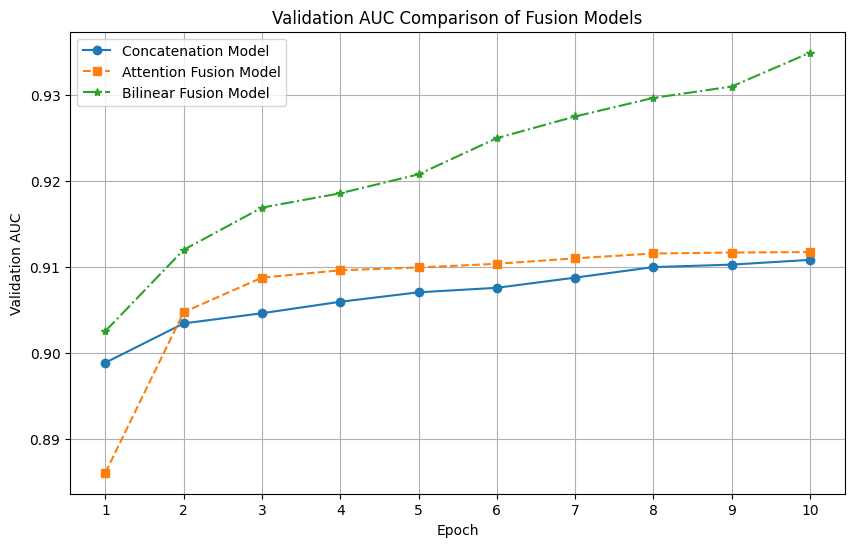

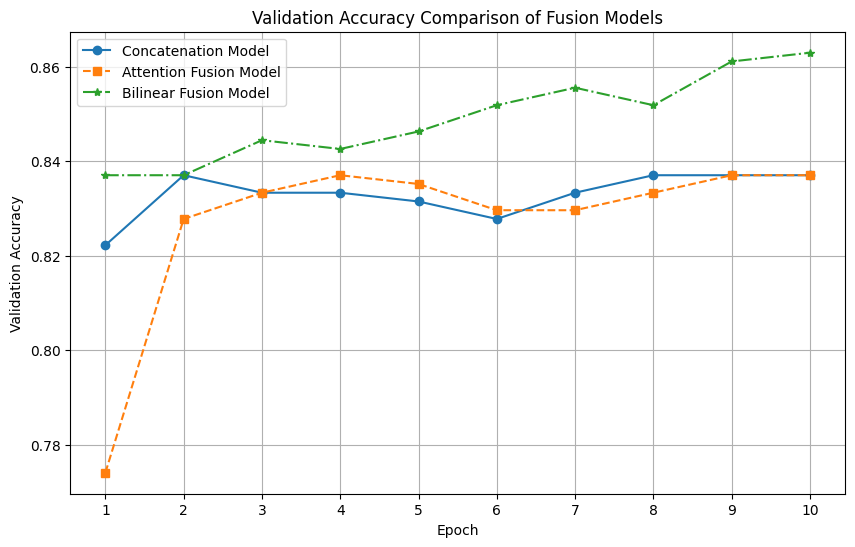

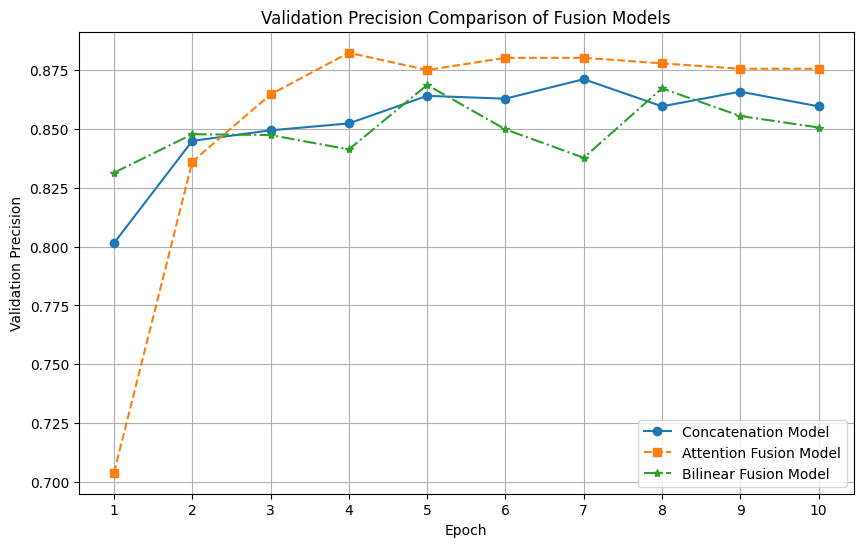

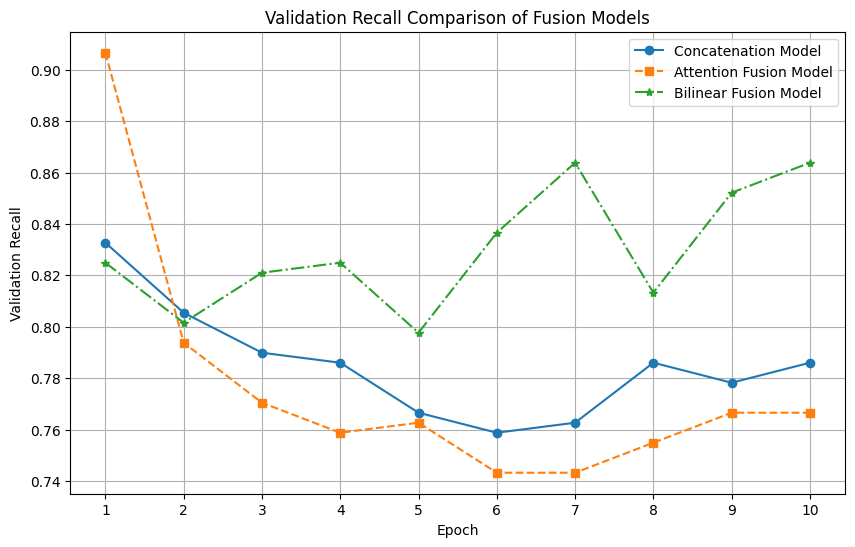

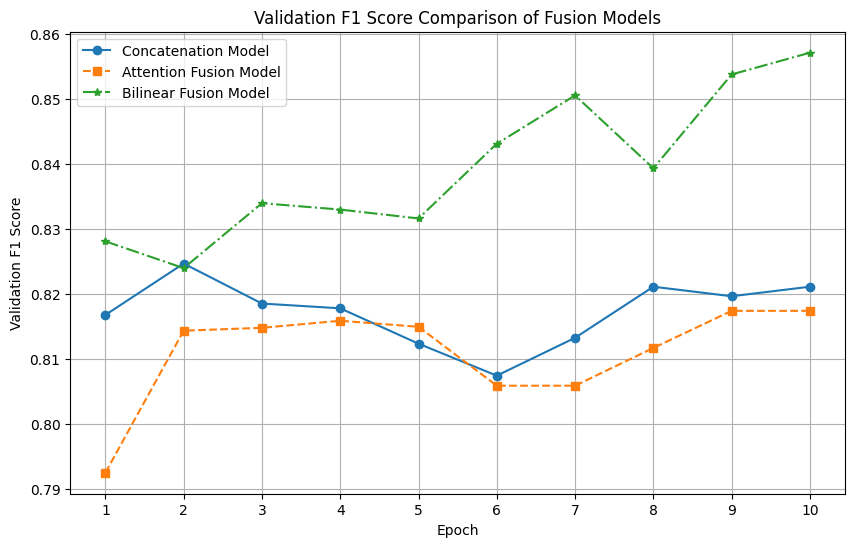

Final Validation Metrics:
  AUC: Concat = 0.9108, Attention = 0.9117, Bilinear = 0.9349
  Accuracy: Concat = 0.8370, Attention = 0.8370, Bilinear = 0.8630
  Precision: Concat = 0.8596, Attention = 0.8756, Bilinear = 0.8506
  Recall: Concat = 0.7860, Attention = 0.7665, Bilinear = 0.8638
  F1 Score: Concat = 0.8211, Attention = 0.8174, Bilinear = 0.8571


In [25]:
# pack your metric histories into a dict
metrics = {
    'AUC':        (concat_aucs,        attention_aucs,        bilinear_aucs),
    'Accuracy':   (concat_accuracies,  attention_accuracies,  bilinear_accuracies),
    'Precision':  (concat_precisions,  attention_precisions,  bilinear_precisions),
    'Recall':     (concat_recalls,     attention_recalls,     bilinear_recalls),
    'F1 Score':   (concat_f1s,         attention_f1s,         bilinear_f1s),
}

epochs = range(1, num_epochs + 1)

model_data = {
    'Concatenation Model': (concat_aucs, concat_accuracies, concat_precisions, concat_recalls, concat_f1s, 'o', '-'),
    'Attention Fusion Model': (attention_aucs, attention_accuracies, attention_precisions, attention_recalls, attention_f1s, 's', '--'),
    'Bilinear Fusion Model': (bilinear_aucs, bilinear_accuracies, bilinear_precisions, bilinear_recalls, bilinear_f1s, '*', '-.'),
}


for metric_name in metrics.keys():
    plt.figure(figsize=(10, 6))
    for model_name, data in model_data.items():
        metric_vals = data[list(metrics.keys()).index(metric_name)]
        marker = data[-2]
        linestyle = data[-1]

        # Only plot if the metric list is not empty
        if metric_vals:
            plt.plot(epochs[:len(metric_vals)], metric_vals, marker=marker, linestyle=linestyle, label=model_name)

    plt.title(f'Validation {metric_name} Comparison of Fusion Models')
    plt.xlabel('Epoch')
    plt.ylabel(f'Validation {metric_name}')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()


# Print final epoch values for quick reference
print("Final Validation Metrics:")
for metric_name, (concat_vals, attn_vals, bilinear_vals) in metrics.items():
    concat_last = f"{concat_vals[-1]:.4f}" if concat_vals else 'N/A'
    attn_last = f"{attn_vals[-1]:.4f}" if attn_vals else 'N/A'
    bilinear_last = f"{bilinear_vals[-1]:.4f}" if bilinear_vals else 'N/A'
    print(f"  {metric_name}: "
          f"Concat = {concat_last}, "
          f"Attention = {attn_last}, "
          f"Bilinear = {bilinear_last}")


Evaluating Baseline DenseNet-121 (Image Only): 100%|██████████| 17/17 [00:10<00:00,  1.61it/s]



--- Model: Baseline DenseNet-121 (Image Only) ---
  Accuracy : 0.8222
  Precision: 0.8207
  Recall   : 0.8016
  F1-score : 0.8110
  ROC AUC  : 0.9011
---------------------------------------------


Evaluating Concatenation Fusion Model: 100%|██████████| 17/17 [00:10<00:00,  1.61it/s]



--- Model: Concatenation Fusion Model ---
  Accuracy : 0.8407
  Precision: 0.8327
  Recall   : 0.8327
  F1-score : 0.8327
  ROC AUC  : 0.9102
---------------------------------------------


Evaluating Attention Fusion Model: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s]



--- Model: Attention Fusion Model ---
  Accuracy : 0.8370
  Precision: 0.8477
  Recall   : 0.8016
  F1-score : 0.8240
  ROC AUC  : 0.9106
---------------------------------------------


Evaluating Bilinear Fusion Model: 100%|██████████| 17/17 [00:10<00:00,  1.61it/s]



--- Model: Bilinear Fusion Model ---
  Accuracy : 0.8407
  Precision: 0.7979
  Recall   : 0.8911
  F1-score : 0.8419
  ROC AUC  : 0.9175
---------------------------------------------


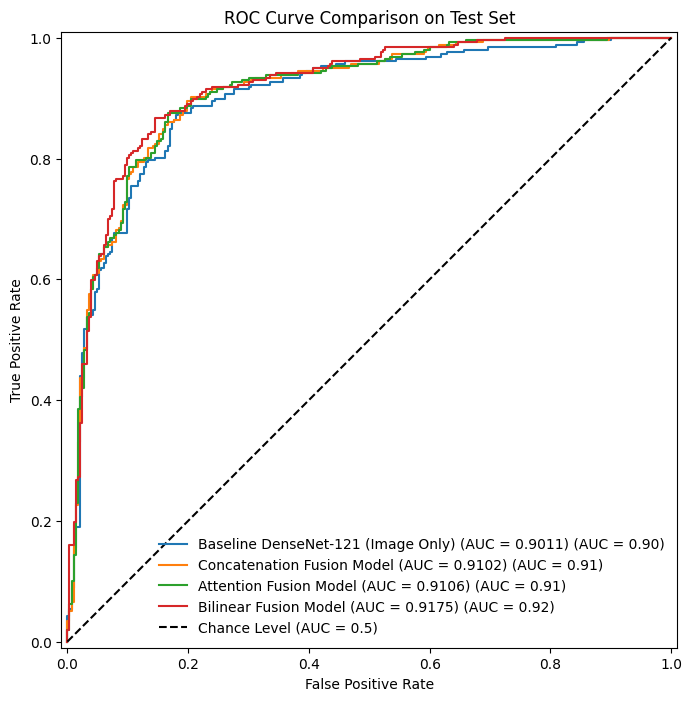

In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, RocCurveDisplay
from torchvision.models import densenet121

# Load pre-trained DenseNet-121
model_densenet = densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, 1)
model_densenet.load_state_dict(torch.load('./densenet121-classification.pth', map_location=device))
model_list  = [model_densenet, concat_model, attention_model, bilinear_model]

all_preds_proba = {}
all_labels      = None
model_names = ['Baseline DenseNet-121 (Image Only)', 'Concatenation Fusion Model', 'Attention Fusion Model', 'Bilinear Fusion Model']

# Main Evaluation Loop
for model, name in zip(model_list, model_names):
    model.eval()
    model.to(device)

    probs_list, labels_list = [], []

    with torch.no_grad():
        # The loader yields three items: images, tabular data, and labels
        for images, tabular, labels in tqdm(test_loader, desc=f"Evaluating {name}"):
            images, tabular = images.to(device), tabular.to(device)

            # Handle different model input signatures
            if "Image Only" in name:
                # The baseline model only takes the image
                out = model(images)
            else:
                # The fusion models take both the image and tabular data
                out = model(images, tabular)

            probs = torch.sigmoid(out).squeeze()

            probs_list.extend(probs.cpu().numpy())
            labels_list.extend(labels.numpy())

    preds_proba = np.array(probs_list)
    labels      = np.array(labels_list)

    all_preds_proba[name] = preds_proba
    if all_labels is None:
        all_labels = labels

    preds_binary = (preds_proba > 0.5).astype(int)

    # Calculate and Print Metrics
    acc     = accuracy_score(labels, preds_binary)
    prec    = precision_score(labels, preds_binary, zero_division=0)
    rec     = recall_score(labels, preds_binary, zero_division=0)
    f1      = f1_score(labels, preds_binary, zero_division=0)
    roc_auc = roc_auc_score(labels, preds_proba)

    print(f"\n--- Model: {name} ---")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")
    print(f"  ROC AUC  : {roc_auc:.4f}")
    print("-" * 45)


# Plot the Combined ROC Curves
plt.figure(figsize=(10, 8))
ax = plt.gca()

for name, preds_proba in all_preds_proba.items():
    auc = roc_auc_score(all_labels, preds_proba)
    RocCurveDisplay.from_predictions(
        all_labels,
        preds_proba,
        name=f'{name} (AUC = {auc:.4f})',
        ax=ax
    )

ax.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison on Test Set')
plt.legend(frameon=False)
plt.show()

Our results show that both multi-modal fusion strategies were effective. Which model was better?

Which strategy performed best and why?

*   If Attention performed better: This is the expected outcome. The attention-based model's superior performance suggests that there are complex, non-linear interactions between the patient's demographics and the visual features of the disease. The gating mechanism allowed the model to learn these interactions, for example, by focusing more on certain lung regions for older patients or weighing texture features differently for male versus female patients. It effectively learned a *context-specific* way to analyze the image.

*   If Concatenation performed better (or they were very close): This can happen, especially with short training times or smaller datasets. It would suggest that the primary benefit comes from simply providing the demographic information to the model, and the simpler concatenation approach was sufficient to capture this benefit. The more complex attention mechanism may have required more data or longer training to learn the intricate relationships without overfitting.

This exercise shows how to implement and compare two powerful multi-modal fusion techniques. While simple concatenation provides a strong baseline, attention-based methods offer a more flexible and powerful framework for integrating different data types, holding the potential for higher accuracy in complex clinical tasks where patient context is key.